LSTM 은 필요 데이터 형태가 달라 앙상블에서 제외

In [5]:
import numpy as np
import pandas as pd
import joblib
import tempfile
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras import backend as K


In [6]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [7]:
# 파일 경로 설정
merged_data_path = 'C:/Users/82106/Desktop/데이터 분석 프로젝트 2/날씨 빅데이터 콘테스트/데이터/merged_data.csv'
merged_data = pd.read_csv(merged_data_path, encoding='cp949')

# 독립 변수 및 종속 변수 설정
X = merged_data.drop(['강수량(mm)', '날짜'], axis=1)  # '날짜' 열과 타겟 열 제외
y = merged_data['강수량(mm)']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Keras로 저장된 모델 불러오기
MLP_model = load_model('C:/Users/82106/Desktop/데이터 분석 프로젝트 2/날씨 빅데이터 콘테스트/model/MLP.keras', custom_objects={'root_mean_squared_error': root_mean_squared_error})

# Scikit-learn 모델 불러오기
RandomForest = joblib.load('C:/Users/82106/Desktop/데이터 분석 프로젝트 2/날씨 빅데이터 콘테스트/model/random_forest_model.pkl')
LinearRegression = joblib.load('C:/Users/82106/Desktop/데이터 분석 프로젝트 2/날씨 빅데이터 콘테스트/model/LinearRegression.pkl')


In [9]:
def predict(self, X):
    # 모델 로드 후 예측
    model = load_model(self.model_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
    
    # 예측 실행
    predictions = model.predict(X)
    
    # 예측 결과가 3차원 배열인 경우 (예: LSTM 모델) 2차원으로 변환
    if predictions.ndim == 3:
        predictions = predictions.reshape(predictions.shape[0], predictions.shape[2])
    elif predictions.ndim == 1:
        # 예측 결과가 1차원 배열인 경우 2차원으로 확장
        predictions = predictions.reshape(-1, 1)
    
    return predictions


In [10]:
import tempfile
import os
from tensorflow.keras.models import save_model, load_model
from sklearn.base import BaseEstimator, RegressorMixin

class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model_path=None):
        self.model_path = model_path

    def fit(self, X, y):
        # 이미 학습된 모델을 사용하므로 fit 메소드는 구현할 필요 없음
        pass

    def predict(self, X):
        # 모델 로드 후 예측
        model = load_model(self.model_path, custom_objects={'root_mean_squared_error': root_mean_squared_error})
        # 예측 결과를 1차원 배열로 변환
        return model.predict(X).flatten()

    def __getstate__(self):
        # 모델 경로를 저장
        return {'model_path': self.model_path}

    def __setstate__(self, state):
        # 모델 경로 복원
        self.model_path = state['model_path']


# 모델을 파일에 저장하고 KerasRegressor 인스턴스 생성 시 파일 경로 전달
temp_dir = tempfile.mkdtemp()

# MLP_model은 이미 존재하는 Keras 모델 객체
MLP_model_path = os.path.join(temp_dir, 'MLP_model.keras')
save_model(MLP_model, MLP_model_path)
MLP_model = KerasRegressor(model_path=MLP_model_path)

# 이제 이 모델들을 VotingRegressor로 구성
from sklearn.ensemble import VotingRegressor

ensemble_model = VotingRegressor(estimators=[
    ('MLP_model', MLP_model),
    ('RandomForest', RandomForest),
    ('LinearRegression', LinearRegression)
])

# 모델 훈련 및 예측
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
RMSE: 7.619279597076301


c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
# 각 모델별 예측값 계산
y_pred_MLP = MLP_model.predict(X_test).flatten()
y_pred_RandomForest = RandomForest.predict(X_test)
y_pred_LinearRegression = LinearRegression.predict(X_test)

# 예측값 출력
print("MLP 예측값 처음 5개:", y_pred_MLP[:5])
print("Random Forest 예측값 처음 5개:", y_pred_RandomForest[:5])
print("Linear Regression 예측값 처음 5개:", y_pred_LinearRegression[:5])


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MLP 예측값 처음 5개: [1.5876675  0.25868607 0.74736696 0.39467448 2.3823445 ]
Random Forest 예측값 처음 5개: [3.1   0.    0.314 0.    0.065]
Linear Regression 예측값 처음 5개: [2.90775034 0.14925985 1.17806036 8.59606773 6.00715604]


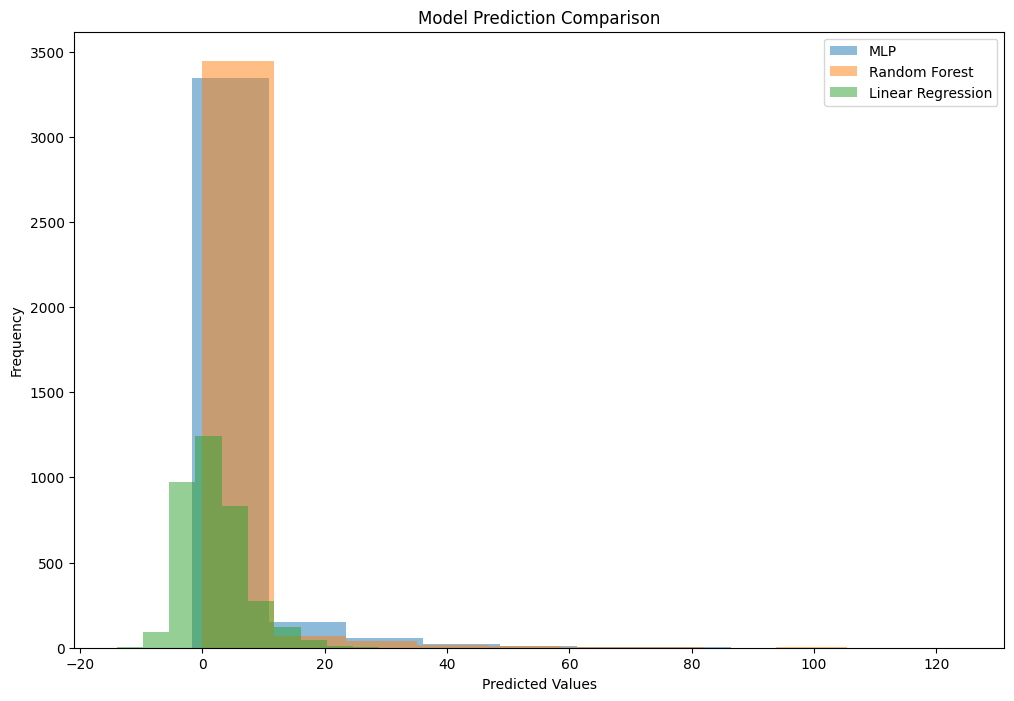

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.hist(y_pred_MLP, alpha=0.5, label='MLP')
plt.hist(y_pred_RandomForest, alpha=0.5, label='Random Forest')
plt.hist(y_pred_LinearRegression, alpha=0.5, label='Linear Regression')
plt.title('Model Prediction Comparison')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### 스태킹 앙상블

In [15]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

stacking_model = StackingRegressor(
    estimators=[
        ('MLP_model', MLP_model),
        ('RandomForest', RandomForest),
        ('LinearRegression', LinearRegression)
    ],
    final_estimator=RandomForestRegressor()  # 메타 모델로 랜덤 포레스트 사용
)


In [16]:
# 모델 훈련 및 예측
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 7.681406285300603


c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 가중평균 앙상블

In [21]:
ensemble_model = VotingRegressor(
    estimators=[
        ('MLP_model', MLP_model),
        ('RandomForest', RandomForest),
        ('LinearRegression', LinearRegression)
    ],
    weights=[3, 1, 1]  # 예를 들어 functional_api와 MLP_model에 높은 가중치 부여
)

In [22]:
# 모델 훈련 및 예측
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 7.496633960518238


c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### 예측 결과 비교 시각화

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


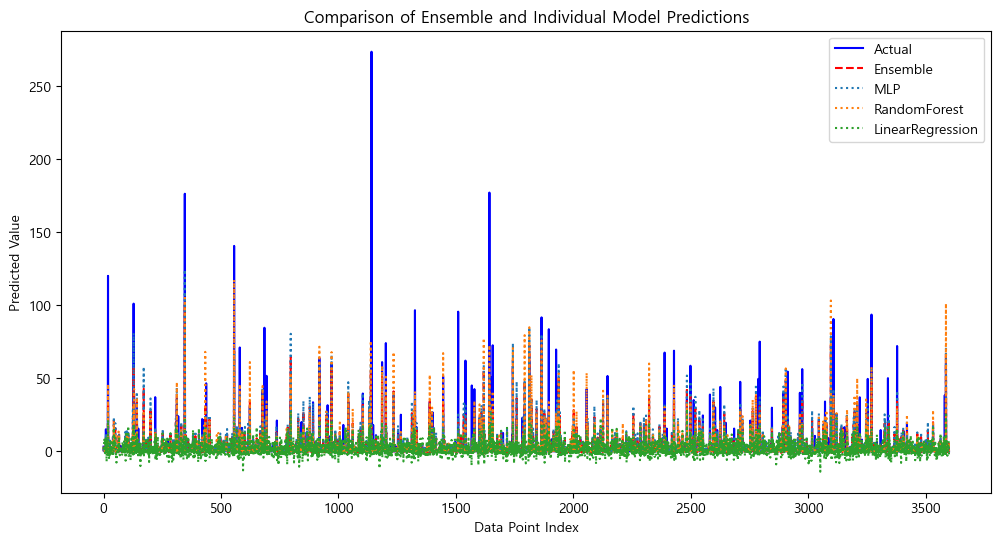

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

#한글폰트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 여기서 'malgun.ttf'는 예시로 사용한 것이며, 실제 한글 폰트 파일로 변경해야 합니다.
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)


# 예측 데이터 생성
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_individual = [model.predict(X_test) for model in [ MLP_model, RandomForest, LinearRegression]]

# 실제 값과 예측 값 비교
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_ensemble, label='Ensemble', color='red', linestyle='--')
for i, model in enumerate(['MLP', 'RandomForest', 'LinearRegression']):
    plt.plot(y_pred_individual[i], label=model, linestyle=':')
plt.title('Comparison of Ensemble and Individual Model Predictions')
plt.xlabel('Data Point Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()


### 피처 중요도 시각화

C:\Users\82106\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


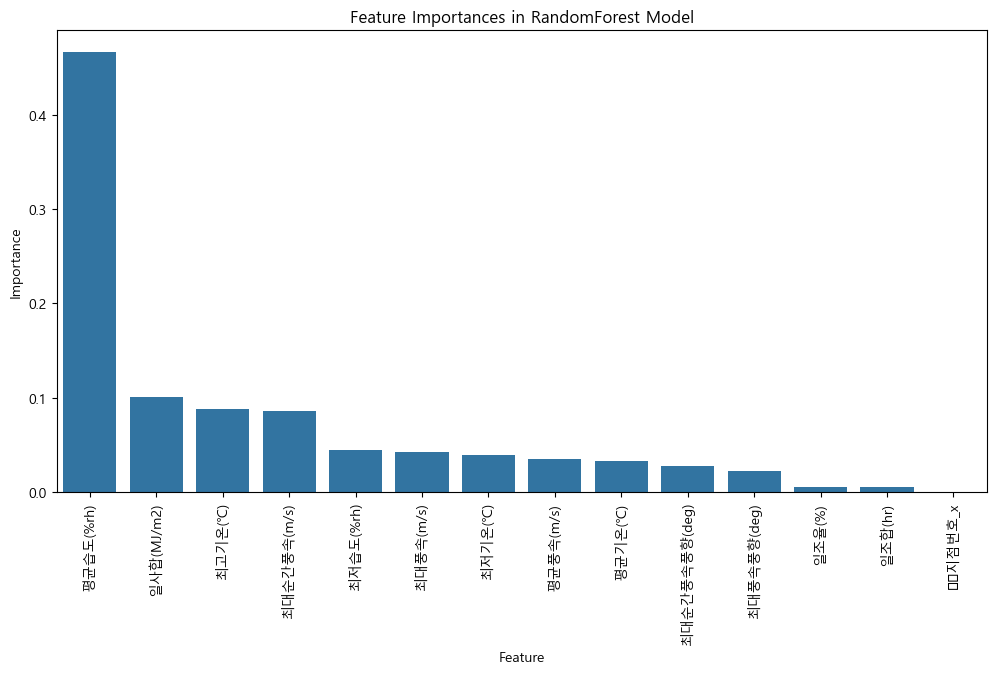

In [28]:
# 트리 기반 모델의 피처 중요도 가져오기
feature_importances = RandomForest.feature_importances_

# 중요도 순으로 피처 정렬
indices = np.argsort(feature_importances)[::-1]

# 피처 중요도 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=X.columns[indices], y=feature_importances[indices])
plt.title('Feature Importances in RandomForest Model')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()


### 에러 분포 시각화

C:\Users\82106\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


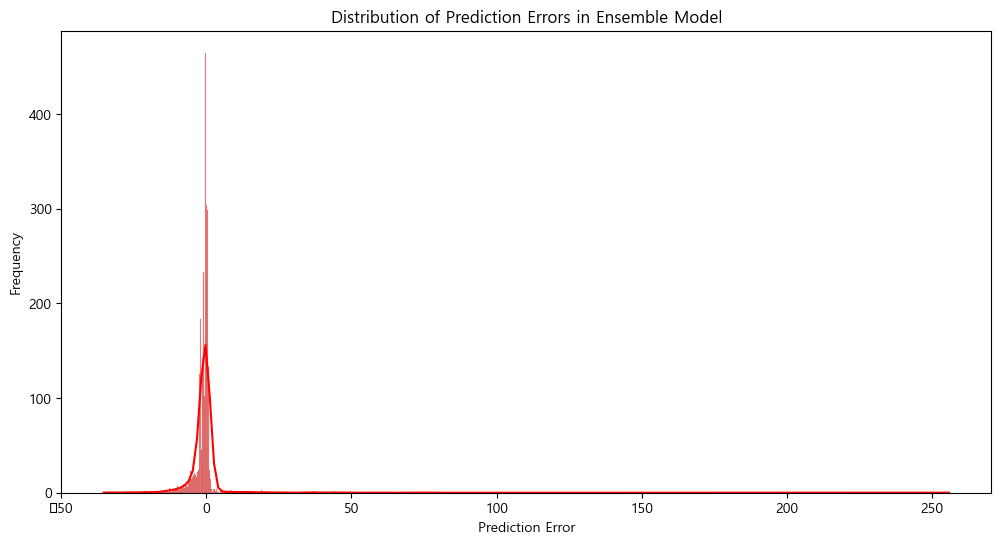

In [29]:
errors = y_test.values - y_pred_ensemble

plt.figure(figsize=(12, 6))
sns.histplot(errors, kde=True, color='red')
plt.title('Distribution of Prediction Errors in Ensemble Model')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()
